# This notebook is to evaluate embedding derived from subnetworks for the HDID data

In [1]:
import sys
sys.path.append("../..")

import pandas as pd
import os
import time
import networkx as nx
from sys import platform 
from src.eda.subset_network import *
from src.eda.eda_functions import *
from src.eda.process_phenotype import *
from src.embedding.network_embedding import network_embedding
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
prefix = 'G:' if platform == 'win32' else '/Volumes/GoogleDrive'

In [4]:
comm_df2 = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/HDID_data/eda_derived/network_louvain2.csv') 
de_data = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/HDID_data/HDID_top_tables_from_mol_neurobio_paper.csv', skiprows=1)

In [5]:
%%time
tom_df = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/HDID_data/TOM_HDID_HS_naive.csv', index_col = 0)

Wall time: 1min 40s


Number of edges: 80483
Figure deg_mod=[0, 1],non_deg_mod=[3],num_genes=100,min_weight=0.069 has been saved.


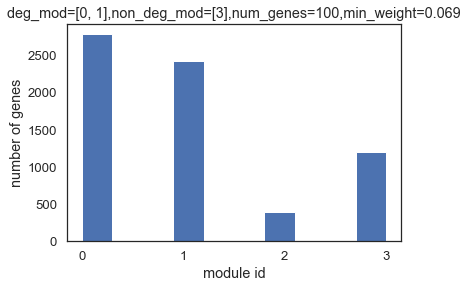

Wall time: 50.3 s


In [11]:
%%time
# New subselection method. This is the biggest change compared to the other notebook. The EDA methods are the same. Only the subselection method is changed. 
G01_n_3, module01_n_3_df, subnetwork_name1 = get_subnetwork([0,1], 100, 0.069, tom_df, comm_df = comm_df2, deseq = de_data, non_deg_modules = [3], 
                                                            plot_hist = False, hist_dir = None, subnetwork_dir = None)
# G012_n_3, module012_n_3_df, subnetwork_name2 = get_subnetwork([0,1,2], 100, 0.068, tom_df, comm_df = comm_df2, deseq = de_data, non_deg_modules = [3], 
#                                                               plot_hist = True, hist_dir = subnetwork_path, subnetwork_dir = subnetwork_path)
# G01_n_23, module01_n_23_df, subnetwork_name3 = get_subnetwork([0,1], 100, 0.077, tom_df, comm_df = comm_df2, deseq = de_data, non_deg_modules = [2,3], 
#                                                               plot_hist = True, hist_dir = subnetwork_path, subnetwork_dir = subnetwork_path)

In [14]:
subnetwork_dfs = [module01_n_3_df, module012_n_3_df, module01_n_23_df]
subnetwork_Gs = [G01_n_3, G012_n_3, G01_n_23]
subnetwork_names = [subnetwork_name1, subnetwork_name2, subnetwork_name3]

### Docker Module Subselection and Embedding (everything from here on belongs to this module)

<font size=5>This took about 1 hour to run

In [31]:
%%time
embedding_path = prefix +'/Shared drives/NIAAA_ASSIST/Data/HDID_data/embedding_derived/embedding_Jan25/'
emb_list = []
kmeans_list = []
for i, G in enumerate(subnetwork_Gs):
    emb_df = network_embedding(G, 16, 100, 10, embedding_path, subnetwork_names[i])
    emb_list.append(emb_df)
    kmeans_list.append(run_kmeans(emb_df, 4)) # I chose k = 4 because the original module # was 4 in comm_df2

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 100/100 [12:16<00:00,  7.36s/it]


embedding data saved


Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 100/100 [12:23<00:00,  7.44s/it]


embedding data saved


Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 100/100 [13:44<00:00,  8.25s/it]


embedding data saved
Wall time: 52min 24s


## Evaluation 1.1: How much is the overlap between the embedding clusters from different subnetworks

### Evalutaion 1.1a: Jaccard to compare cluster similarity

In [32]:
subnetwork_names

['module[0, 1]_n_[3]_df',
 'module[0, 1, 2]_n_[3]_df',
 'module[0, 1]_n_[2, 3]_df']

In [3]:
## The codes here are only when I re-open a session and don't want to redo embeddding, I could just import the embedding df but for containerization, this step is not needed.

# subnetwork_names = []
# for deg, non_deg in zip([[0, 1], [0, 1, 2], [0, 1]], [[3], [3], [2, 3]]):
#     network_name = f'module{deg}_n_{non_deg}_df'
#     subnetwork_names.append(network_name)
# embedding_path = prefix +'/Shared drives/NIAAA_ASSIST/Data/HDID_data/embedding_derived/embedding_Jan25/'
# emb_list = []
# kmeans_list = []
# i = 0
# for file in os.listdir(embedding_path):
#     emb = pd.read_csv(embedding_path + file, index_col = 0)
#     emb_list.append(emb)
#     kmeans_list.append(run_kmeans(emb, 4))
#     i += 1

<font size=6>I chose to compare between the first embedding with the 2nd, 3rd and so on but this should be the user's choice. There's no rule on which one should be compared to which one.

### Plot: jaccard

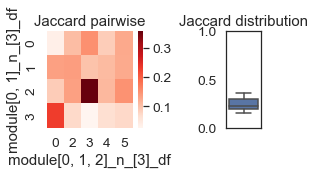

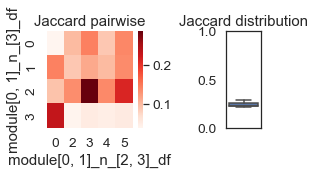

In [34]:
for i in range(1, 3):
    cluster_jaccard(kmeans_list[0], kmeans_list[i], 'kmean_label', [subnetwork_names[0], subnetwork_names[i]], top = 3)

### Evalutaion 1.1b: NMI to compare cluster similarity

### Plot: NMI

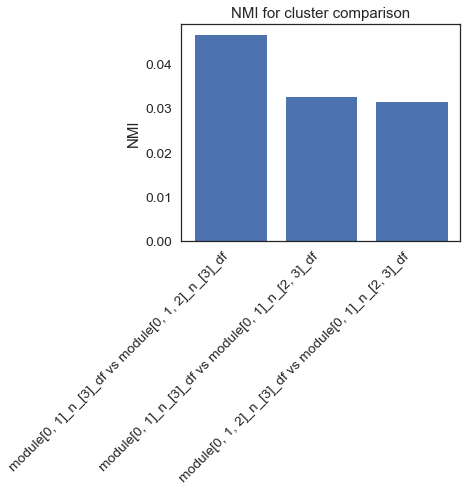

In [74]:
# plot_cluster_nmi_comparison_v2() is new. It's easier for user to customize. I found it to be more useful than plot_cluster_nmi_comparison()
plot_cluster_nmi_comparison_v2([kmeans_list[0], kmeans_list[0], kmeans_list[1]], [kmeans_list[1], kmeans_list[2], kmeans_list[2]], 
                               [subnetwork_names[0], subnetwork_names[0], subnetwork_names[1]], 
                               [subnetwork_names[1], subnetwork_names[2], subnetwork_names[2]], 'kmean_label')

## Evaluation 1.2: How much do cluster and phenotype correlation change when subnetworks (vs whole network) were used for embedding?

### Evaluation 1.2a: compare whole network and subnetwork embedding by % DE in each cluster

### Plot: DE Attributed embedding

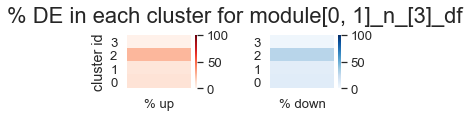

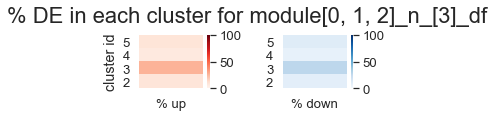

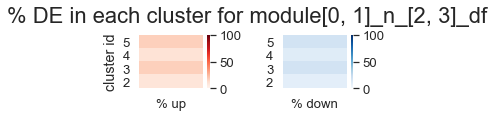

In [76]:
# Note that this is just an example of comparing different subnetwork embedding, not necessarily a great subnetwork example
for i, kmeans in enumerate(kmeans_list):
    cluster_DE_perc(kmeans, 'kmean_label', subnetwork_names[i], deseq = de_data)

### Evaluation 1.2b: Measure percentage of genes in each cluster that are significantly variable for specific traits

### Plot: Cluster-Num Significant genes

In [ ]:
# skipped
# %%time
# for i, kmeans in enumerate(kmeans_list):
#     plot_sig_perc(kmeans, 'kmean_label', subnetwork_names[i], expression_meta_df)

### Evaluation 1.2c: Measure cluster and alcohol phenotype correlation

### Plot: Cluster-Diagnostics corr

In [ ]:
# skipped
# %%time
# for i, kmeans in enumerate(kmeans_list):
#     cluster_phenotype_corr(kmeans, 'kmean_label', subnetwork_names[i], expression_meta_df)